# Second quantised ab initio Hamiltonians with ML quantum states (VMC) - A quickstart guide

This is a short tutorial/overview of methods/open questions for using novel VMC paradigms as a "solver" for ab initio electronic structure problems in second quantization. Although exemplifying the workflow with specific software solutions, this is not meant as a specific software tutorial but rather as a general overview over the workflow. As a general rule, ML-based wavefunctions (in particular, Neural Quantum States) are largely still highly experimental, and a lot of questions are open at this stage. Further: work is required to figure out in what regimes the methods are applicable and to figure out design choices for a robust universal solver - maybe this notebook can help people get involved in these efforts!

In [ ]:
# all the installs + imports necessary for running this notebook
!pip install pyscf
!pip install netket
!pip install git+https://github.com/BoothGroup/GPSKet

import numpy as np
import jax.numpy as jnp

from pyscf import gto, scf, ao2mo, lo, fci, cc

import GPSKet
from GPSKet.hilbert.discrete_fermion import FermionicDiscreteHilbert
from GPSKet.sampler.fermionic_hopping import MetropolisHopping
from GPSKet.operator.hamiltonian.ab_initio import AbInitioHamiltonianOnTheFly
from GPSKet.models import qGPS
from GPSKet.models.pfaffian import ZeroMagnetizationPfaffian
from GPSKet.nn.initializers import normal

import netket as nk

from flax import linen as nn

import matplotlib.pyplot as plt

## The problem definition
Here, we consider ab initio electronic structure Hamiltonians in second quantization
$$
\hat{H} = \sum_{\sigma \in \{\uparrow, \downarrow\}}\sum_{ij=1}^L h^{(1)}_{ij} \hat{c}^\dagger_{j, \sigma} \hat{c}_{i, \sigma} + \frac{1}{2} \sum_{ijkl=1}^L h^{(2)}_{ijkl} \sum_{\sigma, \sigma' \in \{\uparrow, \downarrow\}}\hat{c}^\dagger_{i, \sigma} \hat{c}^\dagger_{j, \sigma'} \hat{c}_{k, \sigma'} \hat{c}_{l, \sigma}.
$$
Here, we consider a fixed number of $N$ electrons occuoying $L$ orbitals.

The Hamiltonian is fully defined by the coefficients $h_{ij}$ and $h_{ijkl}$. There are various different ways to map a physical system to these matrix elements, generated by many ab initio packages in various different ways (downfolding/embedding vs tabulated atomic orbitals vs ...). This is certainly not a tutorial on how to get these values but rather provides a startup kit to using Neural Quantum States (and other Variational Monte Carlo [VMC] models) as a "solver" for these types of Hamiltonians.

Here we consider finding the ground state+evaluating its properties as the "solution" to the electronic structure problem (though solving the stationary Schrodinger equation is certainly not the only problem that could be of interest). In short this means that **we derive a function *solve(h1, h2)* that takes as input the one- and two-electron matrix elements and returns properties of interest of the ground state (energy, 1-RDM, 2-RDM, ...)**.


## VMC as a solver

Neural networks (and various other non-linear functions) can be used to define a wavefucntion ansatz for the ground state mapping an input state from the computational basis, $x$, to a wavefunction amplitude $\Psi(x)$. The configuration $x$ may be seen as a vector describing one allowable electronic configuration of the electrons over the $L$ orbitals (i.e. $x$ can be a length $L$ vector, where each element denotes the occupancy of the corresponding orbital). $\Psi(x)$ can in principle be any model that can be evaluated efficiently, and will be a parametric function depending on a set of variational model parameters.

Now the task is simple: We aim to find an easy-to-use interface that takes in the Hamiltonian parameters and returns a good approximation of the ground state as a model $\Psi(x)$ with optimized parameters, together with the predicted energy, as well as (potentially) other quantities that are useful for integration into practical use cases (in particular 1- and 2-RDMs).

This tutorial will outline the overall workflow of previous applications of VMC/NQS for ab initio problems, however noting that the methodology is still in its infancy and further experimentation is required.

Having chosen an ansatz, the overall workflow in VMC is typically the same:

Expectation values are evaluated according to stochastic sampling from the computational basis,
$$
<E> = <\frac{<x|\hat{H}|\Psi>}{<x|\Psi>}>_{x ∝ |\Psi(x)|^2},
$$
meaning we are generating samples according to the probably distribution $|\Psi(x)|^2$, which are used to estimate expectation values as averages over "local estimators". Then the parametrised ansatz can be optimized by minimization of the energy expectation value (with a lot of standard tricks to make that reliably). See e.g. the standard book https://www.cambridge.org/core/books/quantum-monte-carlo-approaches-for-correlated-systems/EB88C86BD9553A0738BDAE400D0B2900, and https://doi.org/10.21468/SciPostPhysCodeb.7 for introductions into the methodology.

## A small molecule Hamiltonian as a guiding example

As an exemplification of the pipeline, we define a simple Hamiltonian for a H_2 molecule described in a minimal (tabulated) basis set with the python quantum chemistry package [pySCF](https://pyscf.org/).

In [3]:
# Set up system of two H atoms separated by a distance of d=1.8 Angstrom
dist = 1.8

mol = gto.Mole()

mol.build(
    atom=[("H", (x, 0.0, 0.0)) for x in dist * np.arange(2)],
    basis="sto-6g",
    symmetry=True,
    unit="Angstrom",
)

nelec = mol.nelectron
print("Number of electrons: ", nelec)

myhf = scf.RHF(mol)
ehf = myhf.scf()
norb = myhf.mo_coeff.shape[1]
print("Number of molecular orbitals: ", norb)

# Get one- and two-electron integrals for canonical basis

# 1-electron 'core' hamiltonian terms, transformed into MO basis
h1 = np.linalg.multi_dot((myhf.mo_coeff.T, myhf.get_hcore(), myhf.mo_coeff))

# Get 2-electron electron repulsion integrals, transformed into MO basis
eri = ao2mo.incore.general(myhf._eri, (myhf.mo_coeff,) * 4, compact=False)

# Previous representation exploited permutational symmetry in storage. Change this to a 4D array.
# Integrals now stored as h2[p,q,r,s] = (pq|rs) = <pr|qs>. Note 8-fold permutational symmetry.
h2 = ao2mo.restore(1, eri, norb)

Number of electrons:  2
converged SCF energy = -0.837796382593709
Number of molecular orbitals:  2


## Basis choice

Having obtained the one- and two-electron tensors, we can now integrate everything into existing VMC frameworks using NQS as a solver.

Here is where the choices start: There are different choices to rotate the one- and two-electron tensors with unitary (single-body) transformations. This changes the definition of the underlying orthogonalized molecular orbitals and consequently the ground state wavefunction we are modelling with our approach also changes in structure (see e.g. https://doi.org/10.1103/PhysRevB.107.205119)

Broadly speaking there are three different choices

1. "Canonical" orbitals (where the molecular orbitals are determined from a mean-field calculation such as Hartree-Fock)
  
  *This is the standard in conventional post-Hartree-Fock quantum chemistry pipelines*

  - Most wavefunctions will be very peaked
  - The Hamiltonian is dense (O[L^4] non-zero elements)

2. "Local" orbitals (define orthogonal orbitals as linear combinations of the underlying atomic orbitals such that the orbitals are localized in spaces)

  *Various schemes to do the localization exist, effectively choosing different metrics of locality for the orbitals*
  - Most wavefunctions will be very distributed across the full Hilbert space (="dense")
  - The Hamiltonian will become sparse (i.e., many of the $h_{ijkl}$ values go to zero), consequently allowing for pruning these terms from the local energy evaluation

3. A combination of the above or other heuristics (split-local orbitals [this is what DMRG would commonly use], natural orbitals [diagonalize 1-RDM], ...)



The code below shows how to localize the orbitals using PySCF.

In [4]:
# example how to transform orbitals in pySCF

# above orbitals are already in HF (canonical orbital basis)
hij_canonical = h1
hijkl_canonical = h2

# Find the hamiltonian in the local basis
loc_coeff = lo.orth_ao(mol, "meta_lowdin")
loc_coeff = lo.Boys(mol, loc_coeff).kernel()
hij_local = np.linalg.multi_dot((loc_coeff.T, myhf.get_hcore(), loc_coeff))
hijkl_local = ao2mo.restore(1, ao2mo.kernel(mol, loc_coeff), norb)

# split-local basis
loc_coeff_occ = lo.Boys(mol, myhf.mo_coeff[:, : nelec // 2]).kernel()
loc_coeff_vrt = lo.Boys(mol, myhf.mo_coeff[:, nelec // 2 :]).kernel()
loc_coeff = np.concatenate((loc_coeff_occ, loc_coeff_vrt), axis=1)
hij_split = np.linalg.multi_dot((loc_coeff.T, myhf.get_hcore(), loc_coeff))
hijkl_split = ao2mo.restore(1, ao2mo.kernel(mol, loc_coeff), norb)

Having defined the Hamiltonian, we need to integrate with a VMC package as a solver! Various different toolkits exists (mVMC, NetKet, jVMC, ...), and this starting kit is not meant as an answer to the question which one is the best one. While many packages are often in the first instance designed with lattice models in mind, the commong approaches are also directly transferrable to full *ab initio* problems. However, these can be significantly more expensive to perform due to the $O[L^4]$ number of terms in the Hamiltonian, even if these are asynptotially reduced to $O[L^2]$ when using a local basis. This makes the local energy evaluation a key bottleneck in standard applications (which is typically not the case for lattice models), in turn requiring more care in the efficient implementation. This means that it can be beneficial to use low-rank updates of wavefunction evaluations for connected configurations, only differing in their occupancy for up-to two orbitals (see e.g. https://doi.org/10.1063/1.4829835).

For all the different toolkits, there will always be one key question:

### What ansatz should we use for $\Psi(x)$?

The ansatz defines a parameterized function for $\Psi(x)$, whose ability to approximate the true ground state will be crucial to get good results.

Overall, some heuristics have emerged as a guiding principle for the ansatz choice, effectively depending on the basis used for the problem representation.

#### Option A - local basis:

Something with a Fermionic reference state
1. Slater-Jastrow type state
  - See e.g. https://doi.org/10.1063/1.4829835 for a "conventional" Slater-Jastrow model with a very practical introduction and https://doi.org/10.1103/PhysRevB.107.205119 for an application of a systematically-improvable NQS-like ansatz as Jastrow part
  - Overall this ansatz is relatively cheap to evaluate but can sometimes be limited in accuracy, e.g. emerging as a failure to systematically improve the approximated ground state to exactness with machine learning models.

2. Backflow/hidden Fermion models
  - See e.g. https://doi.org/10.48550/arXiv.2502.18843 or https://doi.org/10.1038/s42005-025-02083-4
  - These models are relatively expensive, but can sometimes be a bit more expressive/have shown more reliable systematic-improveability towards the true ground state for benchmarks. Due to the cost, these models have largely only been applied to small test systems.

#### Option B: Canonical basis

Most NQS have been applied in directly in the canonical basis, where the application of raw networks without additional Fermionic structure appears to work ok. However, many (lowly correlated) target states can become very peaked in the canonical basis, which makes states very hard to sample reliably. This means that practically often many samples are required, which can make the method quite costly, see e.g. https://doi.org/10.1038/s41467-020-15724-9. Especially the application of autoregressive models has become very popular (https://doi.org/10.1038/s42256-022-00461-z, https://doi.org/10.48550/arXiv.2208.05637), from which samples can be generated directly, avoiding common issues (such as long autocorrelation times) in the standard Metropolis-Hastings sampling. To also alleviate issues emerging due to the peaked nature of the target probability distribution, purpose-built sampling schemes have been introduced (https://doi.org/10.48550/arXiv.2310.04166, https://doi.org/10.48550/arXiv.2408.07625).

#### Option C: Anything else

Little to no knowledge exists yet.

----

All in all, almost no like-for-like comparison of methods exists yet, still leaving many questions open as to what method performs best in which regimes.

## Software
Different implementations exist, going into detail for all of these in this tutorial is beyond the scope. In the context of this guide, we consider three different implementations and can potentially expand it further in the future.

1. [NetKet](https://netket.readthedocs.io/en/stable/)
  - NetKet is probably the most commonly used VMC library for application of Neural Quantum States in discrete spaces. It is built on JAX and comes with basic support for Fermionic Hamiltonians and an implementation of the Fermionic electronic structure Hamiltonian and common NQS functionality making it easy to experiment with different models/optimizers/workflows, and utilizing GPUs. It should be noted however, that NetKet does currently not support low-rank updates for models, leaving potential efficiency improvements open.

2. [mVMC](https://doi.org/10.1016/j.cpc.2018.08.014)
  - mVMC is a highly optimized VMC library for Fermionic systems in second quantization. While some Neural-Network models are due to be released soon, the main focus is on conventional models such as Slater (and Pfaffian)-Jastrow, and it does not provide an API for custom model implementation with automatic differentiation. The library implements low-rank updates and is very fast to use on CPUs.

3. [GPSKet](https://github.com/BoothGroup/GPSKet)
  - GPSKet is just a collection of custom utility functionality for NetKet, including some custom models, and implementations of efficient ab initio Hamiltonians. This includes the implementation of low-rank updates specifically for the ab initio Hamiltonians outlined above for some specific ansatzes, including a Slater-Jastrow type state with a systematically improvable *GPS* prefactor, which can be seen as a specific neural network architecture.  

## An example implementation

As example implementation, we can now implement the NQS "solver" function. We aim to provide three example implementations using the three libraries above:

- `solve_NetKet(h1, h2, nelec, **kwargs)`
- `solve_mVMC(h1, h2, nelec, **kwargs)`
- `solve_GPSKet(h1, h2, nelec, **kwargs)`

These will be provided in separate files of the repository and show the general workflow for running the solver as a starting point for custom modifications (still to do).


As a guiding example, here we provide an example implementation with the custom implementations from GPSKet, thus following the standard Netket workflow:

1. Set up Hilbert space (defining the computational basis states, here we are also fixing the number of electrons and only allow basis states with the current electron numbers in the respective spin chanels)
2. Set up the Hamiltonian operator
3. We need a way to sample configurations according to $\Psi(x)^2$ (defined by the sampler object). Here we are using a Metropolis-Hastings samplers in which electron hops are proposed as moves
4. Set up an ansatz. We are using a simple Slater determinant multiplied by the GPS model (effectively a single layer Neural Network, whose flexibility can be systematically increased by a single parameter $M$, corresponding to the network width)
5. Run the optimization loop. This uses the standard Stochastic Reconfiguration optimizer (the de-facto standard in VMC).


In [5]:
def solve_GPSKet(h1, h2, nelec, opt_steps=1000):
  norb = h1.shape[0]
  # Set up Hilbert space
  hi = FermionicDiscreteHilbert(norb, n_elec=(nelec // 2, nelec // 2))

  # Set up ab-initio Hamiltonian
  ha = AbInitioHamiltonianOnTheFly(hi, h1, h2)

  # Use Metropolis-Hastings sampler with hopping rule
  sa = MetropolisHopping(hi)

  # Now define a Slater-GPS (a model similar to Slater-Jastrow but with an ML model (the GPS))
  class SlaterGPS(nn.Module):
    SD: nn.module
    GPS: GPSKet.models.qGPS
    apply_fast_update: bool = True
    @nn.compact
    def __call__(self, x, cache_intermediates=False, update_sites=None):
      log_amp_sd = self.SD(x, cache_intermediates=cache_intermediates, update_sites=update_sites)
      log_amp_GPS = self.GPS(x, cache_intermediates=cache_intermediates, update_sites=update_sites)
      return log_amp_sd + log_amp_GPS

  # Choosen a very basic mean-field initialization for the Slater determinant to aid convergence
  eigs, vecs = np.linalg.eigh(h1)
  phi = vecs[:, : mol.nelectron // 2]

  def slater_init(key, shape, dtype=jnp.complex128):
      out = jnp.array(phi).astype(dtype).reshape((1, norb, nelec // 2))
      return out

  # We use M = norb as a heuristic for the support dimension (=network width) of the GPS
  M = norb
  model = SlaterGPS(GPSKet.models.qGPS(hi, M, init_fun=normal(sigma=1.0e-2, dtype=jnp.complex128)), GPSKet.models.slater.Slater(hi, init_fun=slater_init))

  # Define the variational state
  vs = nk.vqs.MCState(sa, model, n_samples=1000)

  # Optimizer
  op = nk.optimizer.Sgd(learning_rate=0.02)
  qgt = nk.optimizer.qgt.QGTJacobianDense(holomorphic=True)
  sr = nk.optimizer.SR(qgt=qgt, diag_shift=0.001)

  # the driver of the optimization loop
  gs = nk.VMC(ha, op, variational_state=vs, preconditioner=sr)

  energies = []
  for i in range(opt_steps):
      gs.advance()
      energies.append(gs.energy.mean)
      print("\r", "Step: {}, Energy: {} ".format(i, gs.energy), end='')

  # after the evaluation one may also evaluate other expectation values (such as the 1-RDM), but we'll leave that for another tutorial

  return energies

Now we can run it!

/usr/local/lib/python3.11/dist-packages/netket/vqs/mc/mc_state/state.py:300: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


 Step: 999, Energy: -1.2647603-0.0000110j ± 0.0000023 [σ²=0.0000000, R̂=1.1335] 

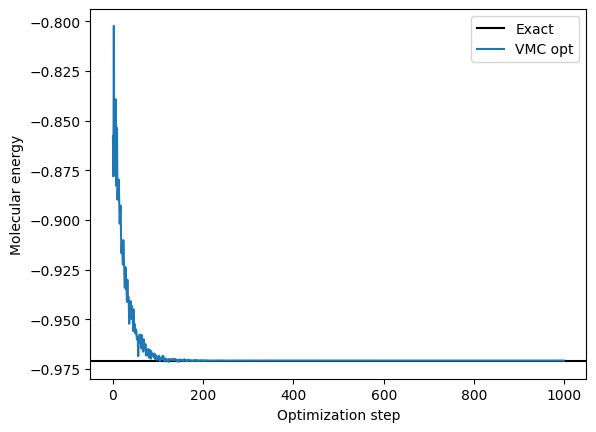

In [6]:
# here we are solving the problem in the local orbital basis to avoid all sampling related issues
energies_GPS = solve_GPSKet(hij_local, hijkl_local, nelec)

# Get the exact energy as a reference
energy, _ = fci.direct_spin0.FCI().kernel(hij_local, hijkl_local, norb, nelec)

# Plot the result (don't forget to add the nuclear repulsion energy)
plt.axhline(energy + mol.energy_nuc(), label="Exact", color="black")
plt.plot(np.array(energies_GPS).real + mol.energy_nuc(), label="VMC opt")
plt.ylabel("Molecular energy")
plt.xlabel("Optimization step")
plt.legend()

Now we can run some more examples... First test a longer chain of 6 H atoms in minimal basis for a symmetric stretching.

Distance: 0.6
converged SCF energy = -2.78331976774626


/usr/local/lib/python3.11/dist-packages/netket/vqs/mc/mc_state/state.py:300: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


 Step: 499, Energy: -10.5043-0.0004j ± 0.0011 [σ²=0.0013, R̂=1.0125] E(CCSD) = -2.830727826071017  E_corr = -0.04740805832475784
CCSD(T) correction = -0.000105929196354012
Distance: 0.8
converged SCF energy = -3.16050935089474
 Step: 499, Energy: -8.98516-0.00007j ± 0.00087 [σ²=0.00077, R̂=1.0027] E(CCSD) = -3.230186889243356  E_corr = -0.06967753834861171
CCSD(T) correction = -0.00020975649378284
Distance: 1.0
converged SCF energy = -3.15600092954731
 Step: 499, Energy: -7.86163-0.00004j ± 0.00090 [σ²=0.00081, R̂=1.0094] E(CCSD) = -3.257214530748513  E_corr = -0.101213601201206
CCSD(T) correction = -0.000425305631312995
Distance: 1.2
converged SCF energy = -3.02626327924134
 Step: 499, Energy: -7.00829-0.00029j ± 0.00053 [σ²=0.00029, R̂=1.0099] E(CCSD) = -3.172725575092334  E_corr = -0.1464622958509944
CCSD(T) correction = -0.000874351142386638
Distance: 1.6
converged SCF energy = -2.68952244151211
 Step: 499, Energy: -5.85570+0.00021j ± 0.00038 [σ²=0.00014, R̂=1.0093] E(CCSD) = -2.98

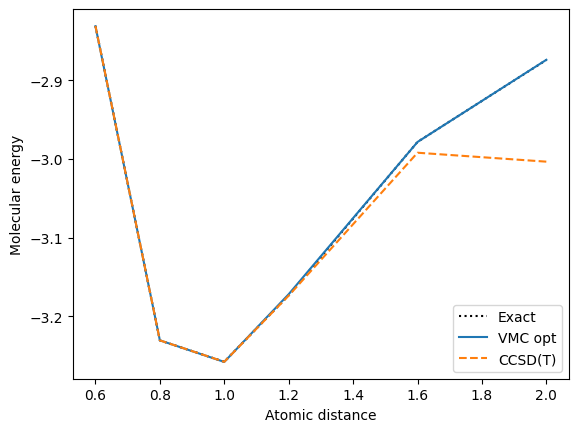

In [7]:
# Set up system of two H atoms separated by a distance of d=1. Angstrom
ens_GPS = []
ens_exact = []
ens_ccsd_t = []

dists = [.6, 0.8, 1., 1.2, 1.6, 2.]
for dist in dists:
  print("Distance: {}".format(dist))
  mol = gto.Mole()

  mol.build(
      atom=[("H", (x, 0.0, 0.0)) for x in dist * np.arange(6)],
      basis="sto-6g",
      symmetry=False,
      unit="Angstrom",
  )

  nelec = mol.nelectron
  myhf = scf.RHF(mol)
  ehf = myhf.scf()
  norb = myhf.mo_coeff.shape[1]
  h1_h6 = np.linalg.multi_dot((myhf.mo_coeff.T, myhf.get_hcore(), myhf.mo_coeff))

  eri = ao2mo.incore.general(myhf._eri, (myhf.mo_coeff,) * 4, compact=False)
  h2_h6 = ao2mo.restore(1, eri, norb)
  loc_coeff = lo.orth_ao(mol, "meta_lowdin")
  localizer = lo.Boys(mol, loc_coeff)
  hij_local_h6 = np.linalg.multi_dot((loc_coeff.T, myhf.get_hcore(), loc_coeff))
  hijkl_local_h6 = ao2mo.restore(1, ao2mo.kernel(mol, loc_coeff), norb)

  # here we are solving the problem in the local orbital basis to avoid all sampling related issues
  ens_GPS.append(solve_GPSKet(hij_local_h6, hijkl_local_h6, nelec, opt_steps=500)[-1].real + mol.energy_nuc())

  # Get the exact energy as a reference
  ens_exact.append(fci.direct_spin1.FCI().kernel(hij_local_h6, hijkl_local_h6, norb, nelec)[0] + mol.energy_nuc())

  # Get CCSD(T) energy as a reference
  mycc = cc.CCSD(myhf).run()
  e_cc = mycc.e_tot
  e_cc_t = mycc.ccsd_t() + e_cc
  ens_ccsd_t.append(e_cc_t)

# Plot the result
plt.plot(dists, ens_exact, label="Exact", color="black", ls=":")
plt.plot(dists, ens_GPS, label="VMC opt")
plt.plot(dists, ens_ccsd_t, label="CCSD(T)", ls="--")
plt.ylabel("Molecular energy")
plt.xlabel("Atomic distance")
plt.legend()

## Benchmarking systems

As it was noted above, currently we don't yet know if/how well/in what instances NQS provide a viable solver for ab initio Hamiltonians in second quantization. We hope this kickstart guide can help people develop new methodology and provide systematic benchmarks.

As a first challenge, a H2O molecule in the 6-31G basis has emerged as am interesting benchmarking problem despite it still being a small system likely with significant finite basis set error (https://doi.org/10.1038/s41467-020-15724-9, https://doi.org/10.1103/PhysRevB.107.205119). Below is a first example implementation to test new custom implementations...

Number of electrons:  10
converged SCF energy = -75.9839420653899
Number of molecular orbitals:  13
 Step: 49, Energy: -84.9865-0.0013j ± 0.0060 [σ²=0.0364, R̂=1.0162] 

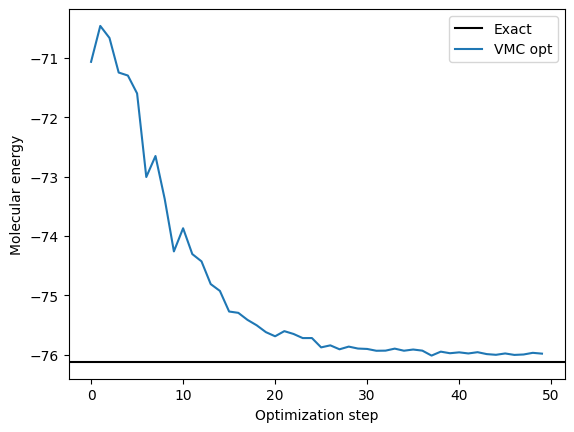

In [8]:
# Construct basis + one- and two-electron integrals with PySCF
mol = gto.Mole()

mol.build(
    atom=[
        ["H", (0.0, 0.795, -0.454)],
        ["H", (0.0, -0.795, -0.454)],
        ["O", (0.0, 0.0, 0.113)],
    ],
    basis="6-31G",
    unit="Angstrom",
)

nelec = mol.nelectron
print("Number of electrons: ", nelec)

myhf = scf.RHF(mol)
ehf = myhf.scf()
norb = myhf.mo_coeff.shape[1]
print("Number of molecular orbitals: ", norb)

h1 = np.zeros((norb, norb))
h2 = np.zeros((norb, norb, norb, norb))

loc_coeff = lo.orth_ao(mol, "meta_lowdin")
localizer = lo.Boys(mol, loc_coeff)
localizer.init_guess = None
loc_coeff = localizer.kernel()
ovlp = myhf.get_ovlp()

# Find the hamiltonian in the local basis
hij_local_water = np.linalg.multi_dot((loc_coeff.T, myhf.get_hcore(), loc_coeff))
hijkl_local_water = ao2mo.restore(1, ao2mo.kernel(mol, loc_coeff), norb)

# here we are solving the problem in the local orbital basis to avoid all sampling related issues
energies_GPS = solve_GPSKet(hij_local_water, hijkl_local_water, nelec, opt_steps=50)

# Get the exact energy as a reference
energy_exact, _ = fci.direct_spin0.FCI().kernel(hij_local_water, hijkl_local_water, norb, nelec)

# Plot the result (don't forget to add the nuclear repulsion energy)
# Plot the result (don't forget to add the nuclear repulsion energy)
plt.axhline(energy_exact + mol.energy_nuc(), label="Exact", color="black")
plt.plot(np.array(energies_GPS).real + mol.energy_nuc(), label="VMC opt")
plt.ylabel("Molecular energy")
plt.xlabel("Optimization step")
plt.legend()

Ultimately, we want to push the methodology towards larger basis set sizes towards the complete basis set limit. Previous benchmarking challenges from the field can serve as a starting point to obtain further data points and see what can be done. For example, hydrogen chains have emerged as a powerful testcase playground to see what can be done (https://doi.org/10.1103/PhysRevX.7.031059, https://doi.org/10.1103/PhysRevX.10.031058), and may equally be a good starting point for further applications of NQS.


To obtain insight into the practicalities of the method, this startup-kit may also serve as a central point to collect and compare further benchmarks towards developing a deeper understanding about NQS as a solver for ab initio electronic structure.

*To be extended with benchmarking results, a hall of fame and more in-depth comparisons between methods...*